In [1]:
import sys
sys.path.append("../")

from src.modelling.feature_extraction import Feature_Extraction as FE
from src.modelling.data_validation import Data_Validation as DV
from src.modelling.hyperparameter_optimization import HyperparameterOpt as HO
from src.modelling.feature_importance import Feature_Importance as FI
from src.modelling.explainability_layer import Explainability_layer as Expl
from src.modelling.model_error_analysis import ModelErrorAnalysis as MEA

from src.data.etl_layer import ETL
from src.data.eda_layer import EDA

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from hyperopt import hp

import joblib
import numpy as np
import pandas as pd

2024-04-16 19:19:42.569000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 19:19:42.569032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 19:19:42.570259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 19:19:42.576457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 19:19:43.443444: W tensorflow/compiler/tf2

# Data preprocessing

## Data loading

In [2]:
# ETL object for sales dataset creation

sales_etl = ETL("../data/raw/sales_train.csv")


2935849 rows and 6 columns has been read from sales_train.csv


### raw sales data validation

In [3]:
# raw data schema and stats
raw_data_DV = DV()
raw_data_DV.load_schema("../data/data_validation/raw_data_schema.pbtxt")
_ =raw_data_DV.load_stats("../data/data_validation/raw_data_stats.txt")

In [4]:
raw_sales_df = sales_etl.get_data().copy()

In [5]:
raw_sales_stats = DV().create_stats(raw_sales_df)
_ = raw_data_DV.validate_data(raw_sales_stats)

The Data Stats has been successfully created


### processed sales data validation

In [6]:
# Raw sales_train.csv data transformation 
sales_etl.transform(["item_cnt_day"], ["item_cnt_day"])
pr_sales_df = sales_etl.get_data()

pr_sales_df.reset_index(drop=True, inplace=True)


306477 outliers were found for the item_cnt_day column.

306477 outliers in column item_cnt_day processed.

Number of rows with missing values: 0

0 rows with N/A values processed.

Number of conflicting or duplicated rows: 6

6 inconsistent or duplicated rows processed.

Сolumns with presumably the wrong data type: 
not numeric type columns: [],
not date type columns: ['date'],
not string type columns: []

DataFrame column types processed.


In [7]:
pr_sales_DV = DV()
pr_sales_stats = pr_sales_DV.create_stats(pr_sales_df)
_ = raw_data_DV.validate_data(pr_sales_stats)

The Data Stats has been successfully created


,Anomaly short description,Anomaly long description
Feature name,,
'date',Column dropped,Column is completely missing


In [8]:
# loading the full processed dataset motnhly_sales and type conversion for 'month' column
monthly_df_etl = ETL(data_path="../data/processed/monthly_sales_full_processed.csv")
monthly_df_etl.data_type_conversion()
monthly_df = monthly_df_etl.get_data()


1609124 rows and 4 columns has been read from monthly_sales_full_processed.csv

Сolumns with presumably the wrong data type: 
not numeric type columns: [],
not date type columns: ['month'],
not string type columns: []

DataFrame column types processed.


## Feature Extraction

In [9]:
train_df_fe = FE(pr_sales_df, monthly_df)
train_df = train_df_fe.get_fe_df()

In [10]:
train_etl = ETL(df=train_df)
train_etl.transform(["item_cnt_month"], ["item_cnt_month"])
train_df = train_etl.get_data()

train_df.reset_index(drop=True, inplace=True)

train_df.head()


1609124 rows and 5 columns has been read from Dataset

43328 outliers were found for the item_cnt_month column.

43328 outliers in column item_cnt_month processed.

Number of rows with missing values: 0

0 rows with N/A values processed.

Number of conflicting or duplicated rows: 86639

86639 inconsistent or duplicated rows processed.

Сolumns with presumably the wrong data type: 
not numeric type columns: [],
not date type columns: [],
not string type columns: []

DataFrame column types processed.


,shop_id,item_id,item_cnt_month,mean_month_price,month_num
0,0,32,1.870712,221.0,1
1,0,33,3.000000,347.0,1
2,0,35,1.000000,247.0,1
3,0,43,1.000000,221.0,1
4,0,51,2.000000,128.5,1


### train dataframe validation

In [11]:
train_DV = DV()
train_DV.load_schema("../data/data_validation/train_data_schema.pbtxt")
train_DV.load_stats("../data/data_validation/train_data_stats.txt")

train_df_stats = DV().create_stats(train_df)
_ = train_DV.validate_data(train_df_stats)

The Data Stats has been successfully created


### train-validation-test data split

In [12]:
X = train_df.drop(["item_cnt_month"], axis=1).values
y = train_df["item_cnt_month"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.3, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=.33, shuffle=False)

# Model Selection
* since the training and testing of models will be performed on their basic hyperparameters, the validation dataset will not be used

In [22]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "SVR": SVR(C=1.0, epsilon=0.5, max_iter=100),
    "XGBoost": XGBRegressor(objective="reg:squarederror"),
    "CatBoost": CatBoostRegressor(100, loss_function="RMSE", verbose=100)
}

for name, model in models.items():
    model.fit(X_train, y_train)  
    predictions = model.predict(X_test)  
    rmse = root_mean_squared_error(y_test, predictions)
    print(f"{name}: RMSE = {rmse:.4f}")

Linear Regression: RMSE = 0.5805
Random Forest: RMSE = 0.6092


/home/user/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR: RMSE = 0.5821
XGBoost: RMSE = 0.5747
Learning rate set to 0.5
0:	learn: 0.5708968	total: 111ms	remaining: 11s
99:	learn: 0.5538938	total: 6.21s	remaining: 0us
CatBoost: RMSE = 0.5737


* save trained model except catboost

In [24]:
joblib.dump(models["Linear Regression"], f'../models/Linear Regression.pkl')
joblib.dump(models["Random Forest"], f'../models/Random Forest.pkl')
joblib.dump(models["SVR"], f'../models/SVR.pkl')
models["XGBoost"].save_model("../models/XGBoost.bin")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:29:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


* The CatBoost model showed the best quality on the test data, so we will take it as the main model (RMSE=0.5737)

# Hyperparameter optimization

In [25]:
catboost_model = CatBoostRegressor

In [16]:
# hyperparameter space

space = {
    'iterations': hp.choice('iterations', [100, 250, 500, 1000, 2000]),
    'depth': hp.choice('depth', [4, 6, 8, 10, 12]),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),  # экспоненциальный диапазон от 0.00001 до 1
    'random_strength': hp.loguniform('random_strength', -20, 0),  # экспоненциальный диапазон
    'border_count': hp.choice('border_count', [32, 64, 128, 254]),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'leaf_estimation_iterations': hp.choice('leaf_estimation_iterations', [1, 5, 10]),
    'leaf_estimation_method': hp.choice('leaf_estimation_method', ['Newton', 'Gradient']),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    'subsample': hp.uniform('subsample', 0.5, 1) if 'bootstrap_type' == 'Bernoulli' else None,  # Доступно только для Bernoulli
    'min_data_in_leaf': hp.choice('min_data_in_leaf', [1, 2, 5, 10, 20]),
    'early_stopping_rounds': hp.choice('early_stopping_rounds', [10, 20, 50])
}


In [ ]:
cb_hyperopt = HO(model=catboost_model, space=space, \
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, X_valid=X_valid, y_valid=y_valid, \
                    add_model_params={"task_type":"CPU", "loss_function":"RMSE", "verbose":False, "use_best_model":True})

cb_hyperopt.hyperopt()

* Let's load the Catboost model with the hyperparameters selected by the above method

In [13]:
model = CatBoostRegressor()
_ = model.load_model("../models/CatBoost")

# Feature Importance

In [14]:
feature_names = train_df.drop("item_cnt_month", axis=1).columns

## Impurity Feature Importance

In [27]:
forest_model = joblib.load("../models/Random Forest.pkl")

In [28]:
forest_fi = FI(forest_model, feature_names=feature_names)

### trained Random Forest Impurity Feature Importance 

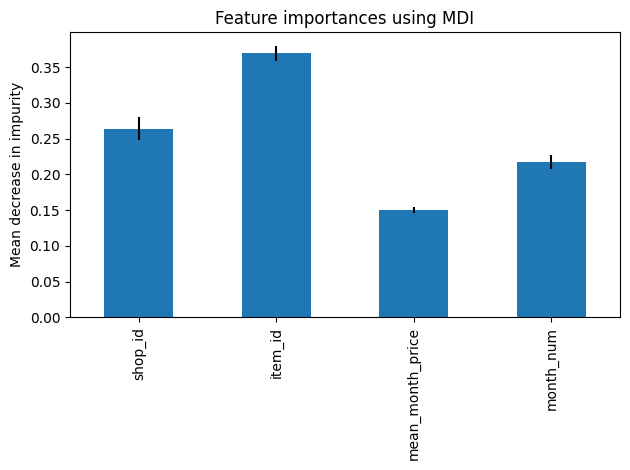

In [29]:
model_std, model_f_importances = forest_fi.fi_impurity()
forest_fi.fi_impurity_visualize(model_std, model_f_importances)

In [30]:
forest_fi.boruta_importance(X_train, y_train, **{"n_estimators":"auto", "max_iter":3, "verbose":2, "random_state":42})

Iteration: 	1 / 3
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	2 / 3
Confirmed: 	0
Tentative: 	4
Rejected: 	0


BorutaPy finished running.

Iteration: 	3 / 3
Confirmed: 	0
Tentative: 	1
Rejected: 	0
Feature: shop_id                   Rank: 4,  Keep: False
Feature: item_id                   Rank: 2,  Keep: False
Feature: mean_month_price          Rank: 3,  Keep: False
Feature: month_num                 Rank: 5,  Keep: False


BorutaPy(estimator=RandomForestRegressor(n_estimators=28,
                                         random_state=RandomState(MT19937) at 0x79EDCA227940),
         max_iter=3, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x79EDCA227940, verbose=2)

# Explainability

In [17]:
Expl(model, X_train, X_test, feature_names).shap_visualization(dep_feature_name="mean_month_price", dep_interaction_feature_name="month_num")

 14%|===                 | 20433/150727 [11:39<74:17]       

# Model Error Analysis

In [16]:
model_error_analysis = MEA(model, X_test, y_test)

Model Metrics: {'MAE': 0.456745989409212, 'MSE': 0.3272531008585853, 'RMSE': 0.5720603996594986}


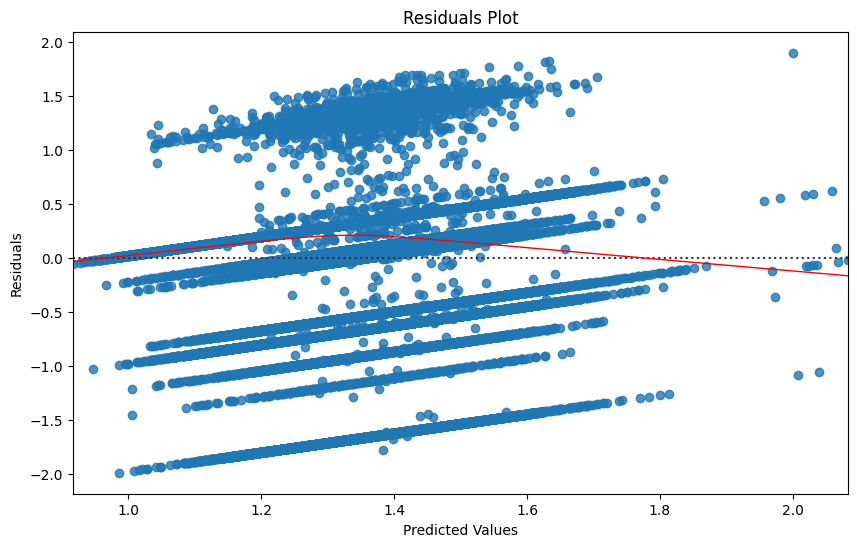

MAE for big targets: 1.442271169717163
MAE for small targets: 0.456745989409212
Influential Samples: [] [] []


In [18]:
metrics = model_error_analysis.calculate_metrics()
print("Model Metrics:", metrics)
model_error_analysis.plot_residuals()
big_target_mae = model_error_analysis.analyze_big_target(np.quantile(y_test, .95))
print("MAE for big targets:", big_target_mae)
small_target_mae = model_error_analysis.analyze_small_target(10)
print("MAE for small targets:", small_target_mae)
influential_X, influential_y, influential_errors = model_error_analysis.find_influential_samples(20)
print("Influential Samples:", influential_X, influential_y, influential_errors)